In [1]:
# preparation of the environment
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path


# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "BertPlausibilityStudy":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm
from torch_set_up import DEVICE
from lagrange_reg_training_bert_snli import BertNliLagrange
from DataModules.SnliDM import ESNLIDataModule

### The metrics

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from notebooks.inference_metrics import *

### Special Render for the Metrics

In [3]:
from notebooks.plausibility_visu import hightlight_txt # function to highlight the text
from notebooks.plots_utils import normalize_attention
from IPython.display import display, HTML

def html_render(model_outputs):
    html = ''

    table_len = len(model_outputs[r'$\lambda$' + "=" + "0.0" ]['AUC'])
    for i in range(table_len):
        html += '<table>'
        html += '<tr><th></th>' # One xtra head for model's name
        for column_name in model_outputs[r'$\lambda$' + "=" + "0.0"].keys():
            html+= '<th>'+ column_name +'</th>'
        html += ' </tr>'
        for name, model_content in model_outputs.items():
            html += '<tr>'
            html += '<td><b>' + name + '</b></td>'

            for k, output in model_content.items():
                displ = output[i] if output is not None else 'N/A'
                if isinstance(displ, float):
                    displ = str(round(displ, 3))
                html += '<td>' + displ + '</td>'

            html += '</tr>'

        html += '</table>'
    return html

### Create the figure to sum up all the metrics

In [4]:
%%capture
fig, axes = plt.subplots(8, 1, figsize = (20, 25))
plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.8)

# set the limits for the axes
y_lims = [(0.5, 1), (-0.01, 0.3), (-0.01, 0.7) ,(-0.01, 1.01), (-0.01, 0.5), (-0.01, 1.01), (-0.01,0.5), (-0.01,1), (-0.01,1)]
for i in range(axes.shape[0]):
        axes[i].set_ylim(y_lims[i][0], y_lims[i][1])

### Regu for the layers 4 to 10

In [5]:
muls = [f"mul={x}" for x in [0.0, 0.01, 0.014, 0.018, 0.02, 0.03, 0.04, 0.05]]

In [6]:
# load the data
import pickle
d = os.path.join(os.getcwd(), ".cache", "plots", "e_snli","regu_study", "lagrange_reg")

# loading the data
a_hat = {}
for mul in muls:
    with open(os.path.join(d, mul, "a_true_head_mean.pickle"), "rb") as f:
        a_true = pickle.load(f)
    with open(os.path.join(d, mul, "layers_4_10_head_mean.pickle"), "rb") as f:
        layers_4_10 = pickle.load(f)
        a_hat[mul] = layers_4_10.copy()
        
a_ones = {}
a_zeros = {}

a_hat_bis = {}
a_true_bis = []
it = 0
for mul in muls:
    buff = []
    for k in ["entailement", "neutral", "contradiction"]:
        buff += list((a_hat[mul][k]))
        if it == 0:
            a_true_bis += list((a_true[k]))
    it += 1
    a_hat_bis[mul] = np.array(buff)
a_true_bis = np.array(a_true_bis)    

for k in ["entailement", "neutral", "contradiction"]:
    a_ones[k] = np.array([1.0] * len(a_true[k]))
    a_zeros[k] = np.array([0.0] * len(a_true[k]))

In [7]:
%%capture
temp = {}
for k in ["entailement", "neutral", "contradiction"]:
    metric_output = {}
    it = 0
    for mul in muls:
        metric_output[mul] = {
                "AUC": [roc_auc_score(a_true[k],a_hat[mul][k])],
                "Jaccard": [scalar_jaccard(a_true[k], a_hat[mul][k])],
                "AUPRC" : [average_precision_score(a_true[k], a_hat[mul][k])],
                "AU - Precision" : [au_precision_curve(a_true[k], a_hat[mul][k])],
                "AU - Recall" : [au_recall_curve(a_true[k], a_hat[mul][k])],
                "Precision (tr)": [precision(a_true[k], a_hat[mul][k])],
                "Recall (tr)": [recall(a_true[k], a_hat[mul][k])],
                "Entropy" : a_hat[mul]["entropy"][k]
        }

    temp[k] = metric_output.copy()

In [8]:
xlab = [r'$\lambda$' + "=" + x.split("=")[-1] for x in list(temp["neutral"].keys())]

In [9]:
%%capture
# complete the graphs
metrics = list(temp["entailement"]["mul=0.0"].keys())

# set the titles
cols = ["Lagrange reg"]
rows = metrics.copy()

for ax, col in zip([axes[0]], cols):
    ax.set_title(col)

for ax, row in zip(axes[:], rows):
    ax.set_ylabel(row, rotation=60, fontsize=15, labelpad=20)

for id_m, m in enumerate(metrics):
    ax = axes[id_m]
    for label in ["entailement", "neutral", "contradiction"]:
        buff = []
        for agreg in temp[label]:
            buff.append(temp[label][agreg][m][0])
            
        x = list(range(1, len(buff)+1))
        ax.scatter(x, buff, label=label)
        ax.set_xticks(x)
        ax.set_xticklabels(xlab,
                           fontsize = 15, 
                           rotation=80)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 10})
        

plt.legend()

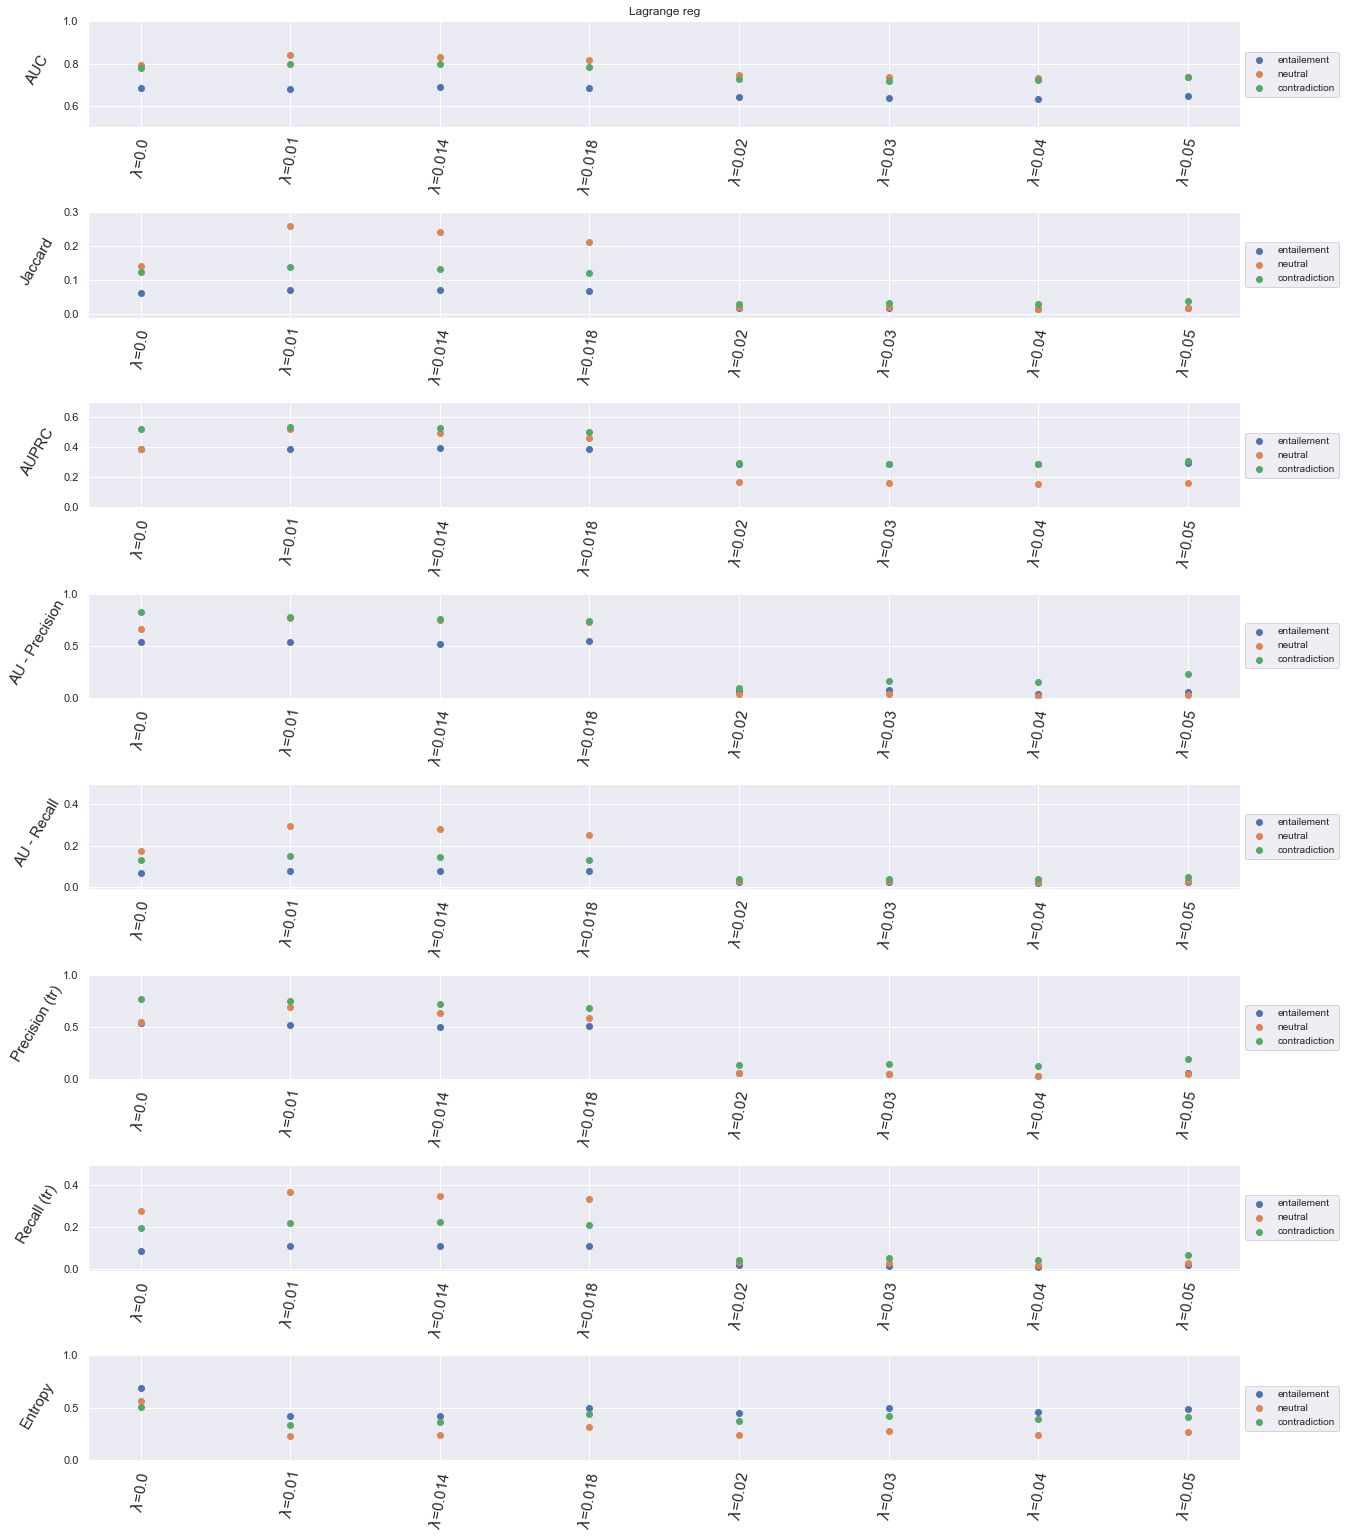

In [10]:
fig

In [11]:
fig.savefig(os.path.join(os.getcwd(),".cache", "plots", "e_snli", "regu_study", "entropy_regu", "metric_graphs.png"))

In [12]:
%%capture
metric_output = {}
it = 0
for mul in muls:
    k = r'$\lambda$' + "=" + mul.split("=")[-1]
    metric_output[k] = {
            "AUC": [roc_auc_score(a_true_bis,a_hat_bis[mul])],
            "Jaccard": [scalar_jaccard(a_true_bis, a_hat_bis[mul])],
            "AUPRC" : [average_precision_score(a_true_bis, a_hat_bis[mul])],
            "AU - Precision" : [au_precision_curve(a_true_bis, a_hat_bis[mul])],
            "AU - Recall" : [au_recall_curve(a_true_bis, a_hat_bis[mul])],
            "Precision (tr)": [precision(a_true_bis, a_hat_bis[mul])],
            "Recall (tr)": [recall(a_true_bis, a_hat_bis[mul])]
    }

In [13]:
display(HTML(html_render(metric_output)))

,AUC,Jaccard,AUPRC,AU - Precision,AU - Recall,Precision (tr),Recall (tr)
$\lambda$=0.0,0.747,0.098,0.415,0.709,0.11,0.627,0.157
$\lambda$=0.01,0.773,0.127,0.457,0.714,0.141,0.651,0.193
$\lambda$=0.014,0.779,0.122,0.452,0.699,0.136,0.618,0.189
$\lambda$=0.018,0.767,0.112,0.432,0.698,0.126,0.595,0.183
$\lambda$=0.02,0.719,0.023,0.261,0.061,0.031,0.085,0.027
$\lambda$=0.03,0.713,0.024,0.256,0.071,0.032,0.082,0.028
$\lambda$=0.04,0.712,0.02,0.256,0.048,0.027,0.06,0.02
$\lambda$=0.05,0.723,0.026,0.265,0.074,0.035,0.099,0.035
